<a href="https://colab.research.google.com/github/Alex5200/221-328-lab-work-main/blob/master/MLclasic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
import os
import re
# Запись в файлы и чтение из файлов структур данных Python
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


!unzip -qo -O CP866 diseases.zip -d dis/

unzip:  cannot find or open diseases.zip, diseases.zip.zip or diseases.zip.ZIP.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
FILE_DIR  = 'dis'                     # Папка с текстовыми файлами
SIG_TRAIN = 'Обучающая'                   # Признак обучающей выборки в имени файла
SIG_TEST  = 'Тестовая'                    # Признак тестовой выборки в имени файла


In [4]:
CLASS_LIST = []
text_train = []
text_test  = []

for file_name in os.listdir(FILE_DIR):
    m = re.match(r'\((.+)\)\s+(\S+)\.txt', file_name)
    if m:
        class_name = m[1]
        subset_name = m[2]
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        if is_train or is_test:
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                text_train.append('')
                text_test.append('')

            cls = CLASS_LIST.index(class_name)
            print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.')
            with open(f'{FILE_DIR}/{file_name}', 'r', encoding='utf-8') as f:
                text = f.read()

            subset = text_train if is_train else text_test
            subset[cls] += ' ' + text.replace('\n', ' ')

# Проверка содержимого списков
print(f'CLASS_LIST: {CLASS_LIST}')
print(f'Количество текстов в обучающей выборке: {len(text_train)}')
if text_train:
    print(f'Количество символов в первом тексте обучающей выборки: {len(text_train[0])}')
else:
    print("Обучающая выборка пуста!")

FileNotFoundError: [Errno 2] No such file or directory: 'dis'

In [ ]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
CLASS_COUNT = len(CLASS_LIST)
for cls in range(CLASS_COUNT):
    print(f'Класс: {CLASS_LIST[cls]}')
    print(f'  train: {text_train[cls][:200]}')
    print(f'  test : {text_test[cls][:200]}')
    print()

Класс: Язва
  train:  тяжесть после приема пищи жгучая боль в животе, которая проходит от пупка до груди тошнота тошнота изжога  появление отрыжки после приема пищи Рвота Ноющие или схваткообразные боли, слабоинтенсивные 
  test :  усталость ощущение тяжести в животе неприятная отрыжка слабость потеря аппетита запоры снижение массы тела тошнота раннее появление чувства сытости снижение веса чередование поноса ,запора и нормальн

Класс: Гастрит
  train:  Боль в эпигастрии (верхней части живота),появляющаяся или усиливающаяся натощак или после приема определенной пищи (острое). -ощущение переполненности в верхней части живота после еды;   -неприятный 
  test :   вздутие живота,  белый налет на языке; тошнота -изжога;  - снижение и ухудшение аппетита; Основными симптоматическими проявлениями болезни являются: чувство тяжести в эпигастрии, чувство тяжести в о

Класс: Колит
  train:  может повышаться температура тела (до 39°С) позывы к дефекации; боль в различных отделах живота При тяжёлой 

In [ ]:
print(CLASS_COUNT)

10


In [ ]:
from collections import Counter

# Подсчет частоты слов в обучающем наборе данных
word_counter = Counter(" ".join(text_train).split())

# Сортировка словаря по частоте встречаемости
most_common_words = word_counter.most_common(10000)  # ТОП-10,000 слов

# Установка размера словаря
VOCAB_SIZE = len(most_common_words)
print(f"Размер словаря: {VOCAB_SIZE}")


Размер словаря: 2495


In [ ]:
# Задание параметров преобразования
VOCAB_SIZE = 2495                        # Объем словаря для токенизатора
WIN_SIZE   = 50                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 25                          # Шаг окна разбиения текста на векторы

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_train)

    # Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())


In [ ]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

[('неизвестное_слово', 1), ('в', 2), ('и', 3), ('боль', 4), ('тошнота', 5), ('или', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('области', 10), ('при', 11), ('животе', 12), ('после', 13), ('отрыжка', 14), ('с', 15), ('аппетита', 16), ('слабость', 17), ('во', 18), ('вздутие', 19), ('пищи', 20), ('изжога', 21), ('тела', 22), ('может', 23), ('рту', 24), ('диарея', 25), ('еды', 26), ('на', 27), ('снижение', 28), ('к', 29), ('верхней', 30), ('повышение', 31), ('до', 32), ('иногда', 33), ('температуры', 34), ('метеоризм', 35), ('части', 36), ('температура', 37), ('не', 38), ('эпигастральной', 39), ('подреберье', 40), ('стул', 41), ('потеря', 42), ('урчание', 43), ('чувство', 44), ('правом', 45), ('ощущение', 46), ('желудка', 47), ('общая', 48), ('отсутствие', 49), ('позывы', 50), ('приема', 51), ('которая', 52), ('ощущения', 53), ('запор', 54), ('понос', 55), ('могут', 56), ('появление', 57), ('время', 58), ('неприятный', 59), ('повышенное', 60), ('нарушение', 61), ('кожи', 62), ('тяжесть

In [ ]:
# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items))

# Проверка индекса слова в словаре
try:
    print('Интересующее слово имеет индекс:', tokenizer.word_index[input('Введите слово: ')])
except:
    print('Интересующего вас слова нет в словаре')

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", text_train[1][:101])
print("Он же в виде последовательности индексов: ", seq_train[1][:20])
# Функция вывода статистики по текстам
def print_text_stats(title, texts, sequences, class_labels=CLASS_LIST):
    # Суммарное количество символов и слов в тексте
    chars = 0
    words = 0

    print(f'Статистика по {title} текстам:')

    # Вывод итогов по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])
        words += len(sequences[cls])

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words))

# Вывод итогов по текстам
print_text_stats('обучающим', text_train, seq_train)
print_text_stats('тестовым', text_test, seq_test)


Размер словаря 1790
Введите слово: боль
Интересующее слово имеет индекс: 4
Фрагмент обучающего текста:
В виде оригинального текста:                Боль в эпигастрии (верхней части живота),появляющаяся или усиливающаяся натощак или после приема опр
Он же в виде последовательности индексов:  [4, 2, 79, 30, 36, 9, 783, 6, 285, 219, 6, 13, 51, 784, 20, 785, 46, 286, 2, 30]
Статистика по обучающим текстам:
Язва                 2644 символов,     352 слов
Гастрит              5966 символов,     743 слов
Колит                7496 символов,     974 слов
Панкреатит           9377 символов,    1221 слов
Холицестит           4589 символов,     630 слов
Гепатит              4507 символов,     561 слов
Эзофагит             4867 символов,     661 слов
Дуоденит             3318 символов,     408 слов
Энтерит              5656 символов,     730 слов
Аппендицит           3242 символов,     459 слов
----
В сумме             51662 символов,    6739 слов

Статистика по тестовым текстам:
Язва              

In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов

    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors

        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    return np.array(x), np.array(y)
    # Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    # Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)




(255, 50) (255, 10)
(43, 50) (43, 10)


In [ ]:
# Вывод отрезка индексов тренировочной выборки
print(x_train[0])

[ 63  13  51  20 151   4   2  12  52 346  76  87  32 347   5   5  21  57
 348  13  51  20   7 152   6 218   8 478   2  39  10 271 131 219   6 349
  13  26   5 753   6 272  41   7 273 479  33  18  58  26]


In [ ]:
# Формирование выборок текстов в виде разреженных матриц (bag of words    # На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование типа

x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

    # Вывод формы обучающей выборки в виде разреженной матрицы Bag of Words
print(x_train_01.shape)
    # Вывод фрагмента отрезка обучающего текста в виде Bag of Words
print(x_train_01[0][0:100])


(255, 2495)
[0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
import numpy as np

# Проверка на наличие каждого класса в тестовых данных
def check_class_presence(y_test, class_labels):
    # Преобразуем y_test из one-hot кодирования в индексы классов
    y_test_classes = np.argmax(y_test, axis=1)  # Получаем индексы классов

    # Подсчитываем количество экземпляров каждого класса в y_test
    class_counts = np.bincount(y_test_classes)

    print(f'Количество экземпляров каждого класса в тестовых данных:')
    for i, class_count in enumerate(class_counts):
        print(f'Класс {class_labels[i]}: {class_count} экземпляров')

    # Проверка на отсутствие классов
    missing_classes = [class_labels[i] for i, count in enumerate(class_counts) if count == 0]

    if missing_classes:
        print(f'\nОтсутствующие классы в тестовых данных: {", ".join(missing_classes)}')
    else:
        print("\nВсе классы присутствуют в тестовых данных!")

# Пример вызова:
check_class_presence(y_test, CLASS_LIST)


Количество экземпляров каждого класса в тестовых данных:
Класс Язва: 3 экземпляров
Класс Гастрит: 2 экземпляров
Класс Колит: 7 экземпляров
Класс Панкреатит: 9 экземпляров
Класс Холицестит: 7 экземпляров
Класс Гепатит: 4 экземпляров
Класс Эзофагит: 4 экземпляров
Класс Дуоденит: 2 экземпляров
Класс Энтерит: 2 экземпляров
Класс Аппендицит: 3 экземпляров

Все классы присутствуют в тестовых данных!


In [ ]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)

    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Проверка, что количество классов в class_labels совпадает с количеством классов в матрице
    if len(class_labels) != cm.shape[0]:
        raise ValueError(f"Количество классов в 'class_labels' ({len(class_labels)}) не совпадает с размерностью матрицы ошибок ({cm.shape[0]})")

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем лишнюю цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток на оси X
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        cls_pred = np.argmax(cm[cls])
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и уверенности
        print(f'Класс: {class_labels[cls]:<20} {100. * cm[cls, cls_pred]:3.0f}% сеть отнесла к классу {class_labels[cls_pred]:<20} - {msg}')

    # Средняя точность распознавания
    print(f'\nСредняя точность распознавания: {100. * cm.diagonal().mean():3.0f}%')

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Оценка работы модели
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │         499,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 502,010 (1.92 MB)

 Trainable params: 501,610 (1.91 MB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1202 - loss: 2.9536 - val_accuracy: 0.2558 - val_loss: 2.2327
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6789 - loss: 1.0950 - val_accuracy: 0.3721 - val_loss: 2.1543
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9504 - loss: 0.3563 - val_accuracy: 0.6047 - val_loss: 2.0885
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.1270 - val_accuracy: 0.6977 - val_loss: 2.0340
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9974 - loss: 0.0584 - val_accuracy: 0.7442 - val_loss: 1.9885
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 0.7907 - val_loss: 1.9503
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accuracy: 0.7907 - val_loss: 1.9177
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.8372 - val_loss: 1.8896
Ep

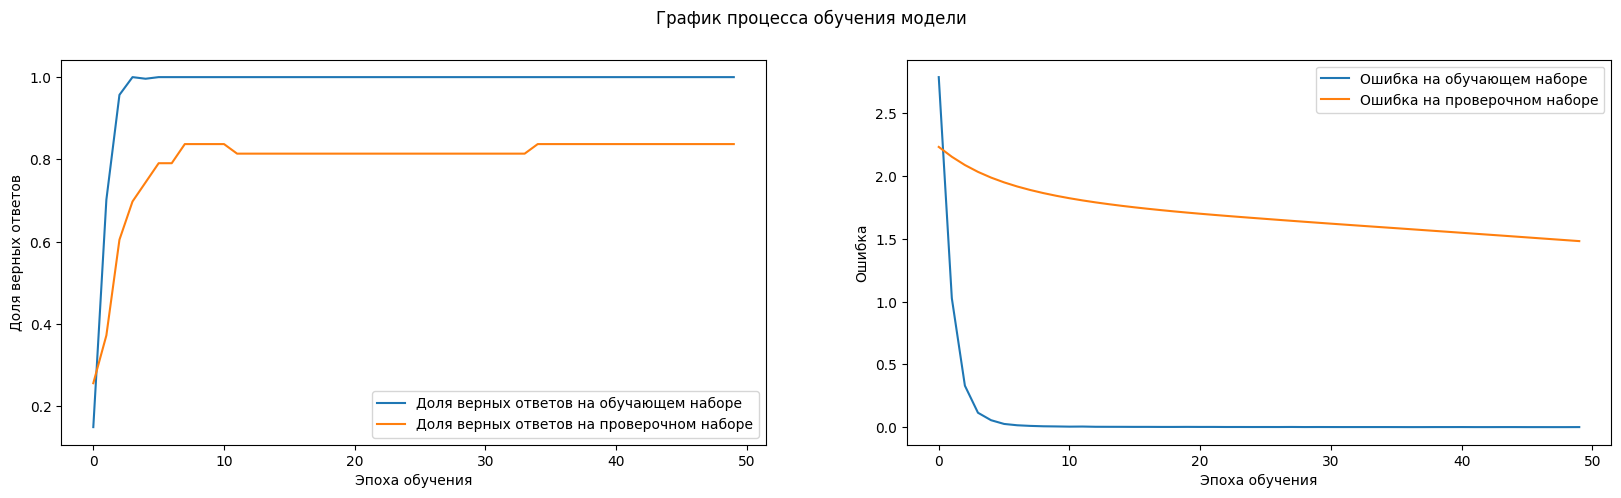

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


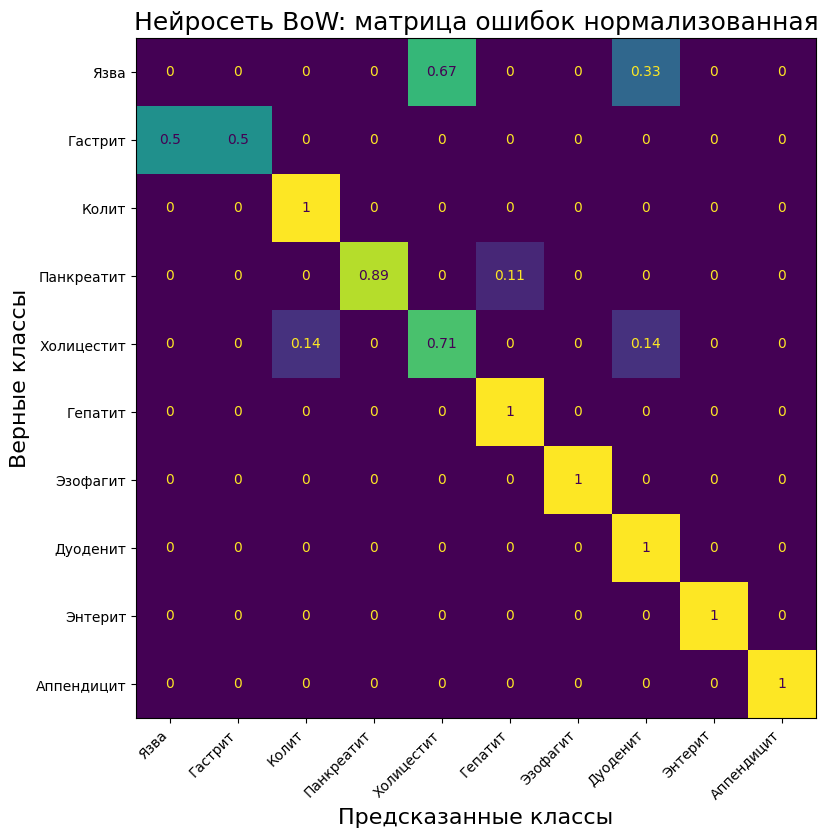

----------------------------------------------------------------------------------------------------
Нейросеть: BoW
Класс: Язва                  67% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Гастрит               50% сеть отнесла к классу Язва                 - НЕВЕРНО :-(
Класс: Колит                100% сеть отнесла к классу Колит                - ВЕРНО :-)
Класс: Панкреатит            89% сеть отнесла к классу Панкреатит           - ВЕРНО :-)
Класс: Холицестит            71% сеть отнесла к классу Холицестит           - ВЕРНО :-)
Класс: Гепатит              100% сеть отнесла к классу Гепатит              - ВЕРНО :-)
Класс: Эзофагит             100% сеть отнесла к классу Эзофагит             - ВЕРНО :-)
Класс: Дуоденит             100% сеть отнесла к классу Дуоденит             - ВЕРНО :-)
Класс: Энтерит              100% сеть отнесла к классу Энтерит              - ВЕРНО :-)
Класс: Аппендицит           100% сеть отнесла к классу Аппендицит           - ВЕРНО :-)


In [ ]:
# Пример создания модели
model_text_bow_softmax = Sequential()
model_text_bow_softmax.add(Dense(200, input_dim=VOCAB_SIZE, activation="relu"))
model_text_bow_softmax.add(Dropout(0.25))
model_text_bow_softmax.add(BatchNormalization())
model_text_bow_softmax.add(Dense(CLASS_COUNT, activation='softmax'))

# Вызываем функцию с вашим набором данных
compile_train_eval_model(model_text_bow_softmax,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,  # Убедитесь, что CLASS_LIST определен и содержит правильное количество классов
                         title='BoW')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.0940 - loss: 3.1164 - val_accuracy: 0.1163 - val_loss: 2.2971
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2898 - loss: 2.0884 - val_accuracy: 0.1860 - val_loss: 2.2921
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4753 - loss: 1.4544 - val_accuracy: 0.2093 - val_loss: 2.2877
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7128 - loss: 0.9862 - val_accuracy: 0.1860 - val_loss: 2.2835
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9034 - loss: 0.5612 - val_accuracy: 0.1860 - val_loss: 2.2797
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9713 - loss: 0.3422 - val_accuracy: 0.2326 - val_loss: 2.2760
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9922 - loss: 0.2248 - val_accuracy: 0.2326 - val_loss: 2.2723
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9948 - loss: 0.1545 - val_accuracy: 0.2326 - val_loss: 2.2691
Ep

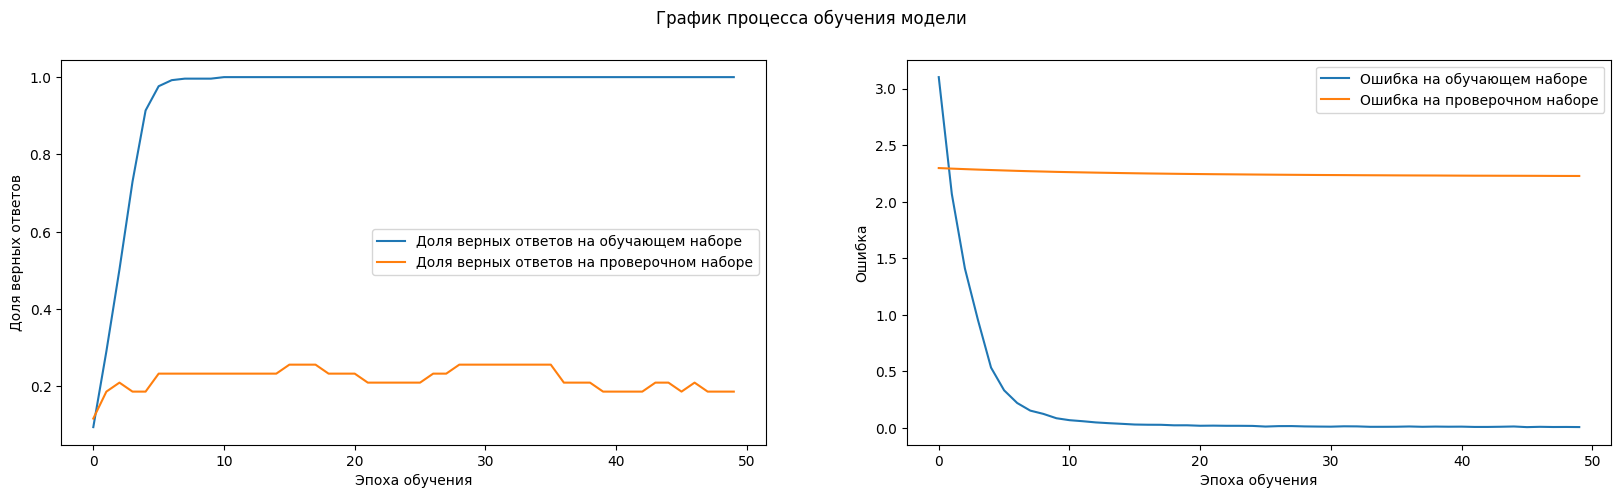

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


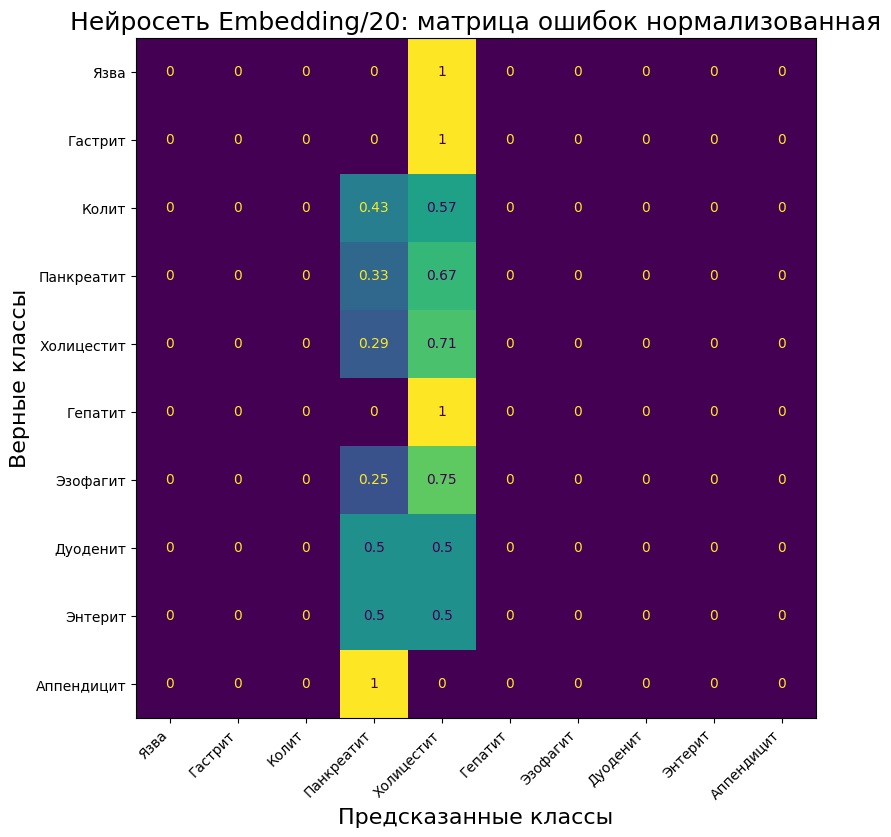

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/20
Класс: Язва                 100% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Гастрит              100% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Колит                 57% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Панкреатит            67% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Холицестит            71% сеть отнесла к классу Холицестит           - ВЕРНО :-)
Класс: Гепатит              100% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Эзофагит              75% сеть отнесла к классу Холицестит           - НЕВЕРНО :-(
Класс: Дуоденит              50% сеть отнесла к классу Панкреатит           - НЕВЕРНО :-(
Класс: Энтерит               50% сеть отнесла к классу Панкреатит           - НЕВЕРНО :-(
Класс: Аппендицит           100% сеть отнесла к классу Панкреатит  

In [ ]:
# Архитектура со слоем Embedding и регуляризацией
model_text_emb_20 = Sequential()
model_text_emb_20.add(Embedding(input_dim = VOCAB_SIZE, output_dim = 20, input_length=WIN_SIZE))
model_text_emb_20.add(SpatialDropout1D(0.2))
model_text_emb_20.add(Flatten())
model_text_emb_20.add(BatchNormalization())
model_text_emb_20.add(Dense(200, activation="relu"))
model_text_emb_20.add(Dropout(0.2))
model_text_emb_20.add(BatchNormalization())
model_text_emb_20.add(Dense(CLASS_COUNT, activation='softmax'))

# Входные данные подаются в виде последовательностей индексов,
# а не векторов bag of words
compile_train_eval_model(model_text_emb_20,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         title='Embedding/20')


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(CLASS_COUNT),
    y=y_train.argmax(axis=1)
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.9615384615384615, 1: 0.9107142857142857, 2: 0.6891891891891891, 3: 0.5425531914893617, 4: 1.0625, 5: 1.2142857142857142, 6: 1.02, 7: 1.7, 8: 0.9107142857142857, 9: 1.5}


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.1484 - loss: 2.7367 - val_accuracy: 0.0000e+00 - val_loss: 2.3439
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5799 - loss: 1.2655 - val_accuracy: 0.0000e+00 - val_loss: 2.3778
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7893 - loss: 0.6200 - val_accuracy: 0.0000e+00 - val_loss: 2.4111
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9047 - loss: 0.3070 - val_accuracy: 0.0000e+00 - val_loss: 2.4471
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9669 - loss: 0.1900 - val_accuracy: 0.0000e+00 - val_loss: 2.4857
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9735 - loss: 0.0771 - val_accuracy: 0.0000e+00 - val_loss: 2.5273
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0555 - val_accuracy: 0.0000e+00 - val_loss: 2.5675
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9988 - loss: 0.0423 - val_accuracy: 0.

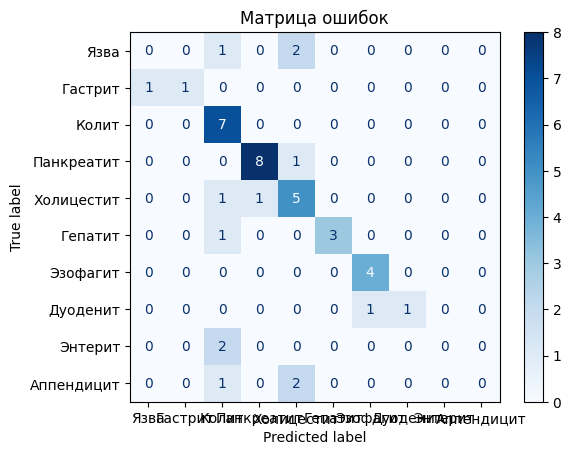

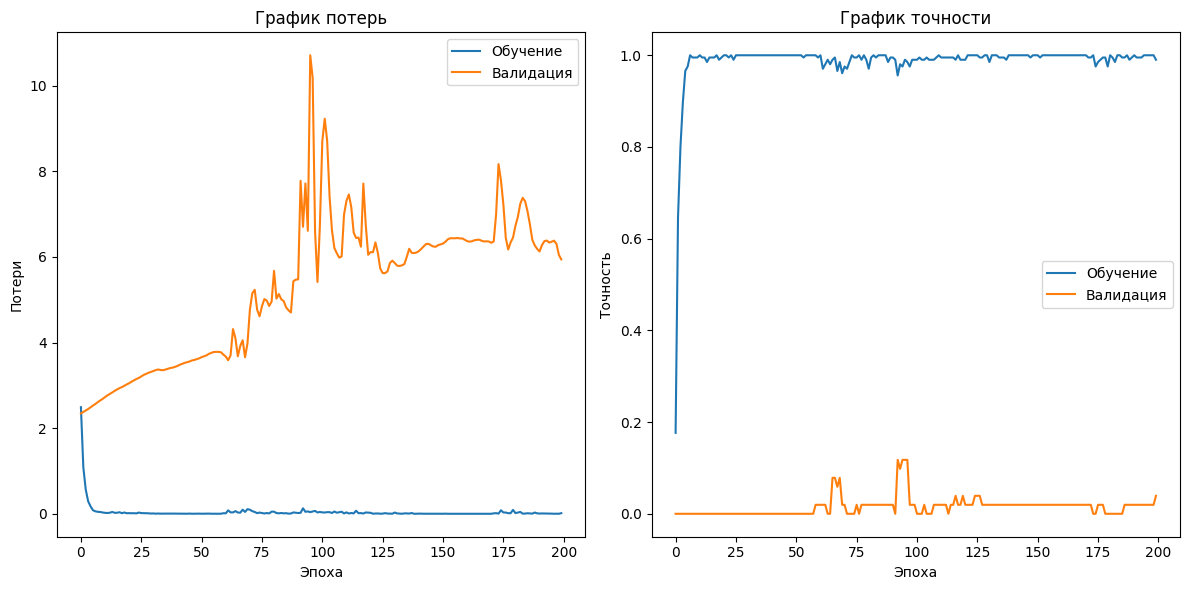

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Убедитесь, что VOCAB_SIZE, WIN_SIZE, CLASS_COUNT, x_train, y_train, x_test, y_test, CLASS_LIST определены заранее

# Создание модели с Embedding и LSTM
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=500, input_length=WIN_SIZE),

    # Добавлены два слоя SpatialDropout1D
    SpatialDropout1D(0.2),
    SpatialDropout1D(0.2),

    # Добавлены два слоя LSTM
    LSTM(256, return_sequences=True),
    LSTM(128, return_sequences=True),

    # Добавлены два слоя GlobalAveragePooling1D
    GlobalAveragePooling1D(),

    # Добавлены два слоя BatchNormalization
    BatchNormalization(),
    BatchNormalization(),

    # Добавлены два полносвязных слоя Dense с Dropout
    Dense(400, activation='relu'),
    Dropout(0.3),
    Dense(200, activation='relu'),
    Dropout(0.3),

    # Добавлены два слоя BatchNormalization перед выходным слоем
    BatchNormalization(),
    BatchNormalization(),

    # Выходной слой
    Dense(CLASS_COUNT, activation='softmax')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Подсчет весов классов на основе y_train
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Обучение модели с использованием class_weights_dict
history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict  # <-- Важно! Здесь используется class_weights_dict
)

# Оценка на тестовой выборке
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Получаем предсказания модели
predictions = model.predict(x_test)

# Преобразование one-hot в метки классов
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

# Названия классов
class_labels = CLASS_LIST  # Убедитесь, что CLASS_LIST определен заранее и соответствует порядку классов

correct_count = 0

print("Нейросеть с Embedding\n")

# Цикл по всем тестовым данным
for i in range(len(true_labels)):
    true_class_index = true_labels[i]
    predicted_class_index = predicted_labels[i]

    # Вероятность для предсказанного класса
    predicted_probability = predictions[i][predicted_class_index] * 100

    # Названия классов
    true_class_name = class_labels[true_class_index]
    predicted_class_name = class_labels[predicted_class_index]

    # Проверка правильности предсказания
    is_correct = true_class_index == predicted_class_index
    correctness = "ВЕРНО :-)" if is_correct else "НЕВЕРНО :-("

    # Подсчет количества правильных предсказаний
    if is_correct:
        correct_count += 1

    # Вывод результата для текущего примера
    print(f"Класс: {true_class_name:<20} {predicted_probability:.0f}% сеть отнесла к классу {predicted_class_name:<20} - {correctness}")

# Подсчет средней точности
average_accuracy = (correct_count / len(true_labels)) * 100
print(f"\nСредняя точность распознавания: {average_accuracy:.0f}%")

# Вывод матрицы ошибок
cm = confusion_matrix(true_labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Печать матрицы ошибок
cm_display.plot(cmap='Blues')
plt.title("Матрица ошибок")
plt.show()

# График процесса обучения
plt.figure(figsize=(12, 6))

# Потери для обучающей и валидационной выборок
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

# Точность для обучающей и валидационной выборок
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.title('График точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()
